In [2]:
import os
import pandas as pd
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score, f1_score, precision_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import Callback
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
def read_and_rename_file(file_path):
    df = pd.read_csv(file_path, skiprows=22, header=None, delimiter='\t')
    df.columns = ['indices', 'velocidade', 'AceleracaoX', 'AceleracaoY', 'AceleracaoZ']
    return df

def determine_damage(filename):
    if filename.startswith("H"):
        return "Saudável"
    elif "0.5X" in filename:
        return "Moderado"
    else:
        return "Severo"

def is_variable_speed(filename):
    return 1 if "VS" in filename else 0

def calculate_variable_speed(index):
    sampling_frequency = 25600
    time = index
    time_in_cycle = time % 2

    if time_in_cycle <= 1.0:
        speed = time_in_cycle * 40
    else:
        speed = 40 - (time_in_cycle - 1) * 40

    return round(speed * 2) / 2

def extract_condition(df, filename):
    if "VS" in filename:
        df['Condição'] = df['indices'].apply(calculate_variable_speed)
    else:
        condition = filename.split('_')[-1].replace('.xls', '').replace('Hz', '')
        df['Condição'] = int(condition) if condition.isdigit() else None
    return df

In [4]:
# Diretório com os arquivos
data_dir = "/Users/enzooliveira/Pessoal/VS CODE/IC/raw data"

# Lista para armazenar os dataframes
all_dataframes = []

# Processar cada arquivo
for filename in os.listdir(data_dir):
    if filename.endswith(".xls"):
        file_path = os.path.join(data_dir, filename)
        df = read_and_rename_file(file_path)

        df['VelocidadeConstante'] = is_variable_speed(filename)
        df['Dano'] = determine_damage(filename)

        # Aplicar a lógica da condição
        df = extract_condition(df, filename)

        # Adicionar uma coluna com o nome do arquivo
        df['Arquivo'] = filename

        # Adicionar o dataframe à lista
        all_dataframes.append(df)

# Concatenar todos os dataframes em um único dataframe
df= pd.concat(all_dataframes, ignore_index=True)

df

/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_7253/3429283940.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df= pd.concat(all_dataframes, ignore_index=True)


,indices,velocidade,AceleracaoX,AceleracaoY,AceleracaoZ,VelocidadeConstante,Dano,Condição,Arquivo
0,0.000000,0.062811,-0.005853,0.034844,-0.055663,0,Severo,40.0,B_40Hz.xls
1,0.000039,0.065399,0.009108,0.037469,-0.050143,0,Severo,40.0,B_40Hz.xls
2,0.000078,0.069251,0.018196,0.040567,-0.015191,0,Severo,40.0,B_40Hz.xls
3,0.000117,0.068802,0.050685,0.025236,-0.071849,0,Severo,40.0,B_40Hz.xls
4,0.000156,0.066454,-0.023585,0.024446,-0.000025,0,Severo,40.0,B_40Hz.xls
...,...,...,...,...,...,...,...,...,...
25952251,10.239805,5.002699,-0.281512,0.179481,-0.175507,0,Moderado,60.0,0.5X_C_60Hz.xls
25952252,10.239844,5.000125,0.013449,0.185089,-0.234294,0,Moderado,60.0,0.5X_C_60Hz.xls
25952253,10.239883,4.999646,0.109414,0.174463,-0.062894,0,Moderado,60.0,0.5X_C_60Hz.xls
25952254,10.239922,4.997449,0.092863,0.082801,-0.049218,0,Moderado,60.0,0.5X_C_60Hz.xls


In [5]:
# Remover as colunas 'indices' e 'velocidade'
df = df.drop(columns=['indices', 'velocidade'])

print(df.head())  # Mostrar as primeiras linhas do DataFrame sem as colunas

   AceleracaoX  AceleracaoY  AceleracaoZ  VelocidadeConstante    Dano  \
0    -0.005853     0.034844    -0.055663                    0  Severo   
1     0.009108     0.037469    -0.050143                    0  Severo   
2     0.018196     0.040567    -0.015191                    0  Severo   
3     0.050685     0.025236    -0.071849                    0  Severo   
4    -0.023585     0.024446    -0.000025                    0  Severo   

   Condição     Arquivo  
0      40.0  B_40Hz.xls  
1      40.0  B_40Hz.xls  
2      40.0  B_40Hz.xls  
3      40.0  B_40Hz.xls  
4      40.0  B_40Hz.xls  


In [6]:
# Remover as colunas 'indices' e 'velocidade'
df = df.drop(columns=['Dano'])

print(df.head())  # Mostrar as primeiras linhas do DataFrame sem as colunas

   AceleracaoX  AceleracaoY  AceleracaoZ  VelocidadeConstante  Condição  \
0    -0.005853     0.034844    -0.055663                    0      40.0   
1     0.009108     0.037469    -0.050143                    0      40.0   
2     0.018196     0.040567    -0.015191                    0      40.0   
3     0.050685     0.025236    -0.071849                    0      40.0   
4    -0.023585     0.024446    -0.000025                    0      40.0   

      Arquivo  
0  B_40Hz.xls  
1  B_40Hz.xls  
2  B_40Hz.xls  
3  B_40Hz.xls  
4  B_40Hz.xls  


In [7]:
# Substituir todos os valores NaN por 25.0
df = df.fillna(25.0)

# Verificar se ainda há valores NaN
print("Há valores NaN após a substituição?", df.isnull().values.any())

Há valores NaN após a substituição? False


In [8]:
df = df.drop(columns=['VelocidadeConstante'])

print(df.head())  # Mostrar as primeiras linhas do DataFrame sem as colunas

   AceleracaoX  AceleracaoY  AceleracaoZ  Condição     Arquivo
0    -0.005853     0.034844    -0.055663      40.0  B_40Hz.xls
1     0.009108     0.037469    -0.050143      40.0  B_40Hz.xls
2     0.018196     0.040567    -0.015191      40.0  B_40Hz.xls
3     0.050685     0.025236    -0.071849      40.0  B_40Hz.xls
4    -0.023585     0.024446    -0.000025      40.0  B_40Hz.xls


In [9]:
import pandas as pd

# Filtrar arquivos pelo prefixo e atualizar a coluna Dano_Binário para Tipo_Dano com valores específicos
df_I = df[df['Arquivo'].str.startswith('I_')].copy()
df_I.rename(columns={'Dano_Binário': 'Tipo_Dano'}, inplace=True)
df_I['Tipo_Dano'] = '0001'

df_B = df[df['Arquivo'].str.startswith('B_')].copy()
df_B.rename(columns={'Dano_Binário': 'Tipo_Dano'}, inplace=True)
df_B['Tipo_Dano'] = '0010'

df_C = df[df['Arquivo'].str.startswith('C_')].copy()
df_C.rename(columns={'Dano_Binário': 'Tipo_Dano'}, inplace=True)
df_C['Tipo_Dano'] = '0100'

df_O = df[df['Arquivo'].str.startswith('O_')].copy()
df_O.rename(columns={'Dano_Binário': 'Tipo_Dano'}, inplace=True)
df_O['Tipo_Dano'] = '1000'

# Exibir informações sobre os DataFrames criados
print(f"Tamanho de df_I: {df_I.shape[0]} linhas")
print(f"Tamanho de df_B: {df_B.shape[0]} linhas")
print(f"Tamanho de df_C: {df_C.shape[0]} linhas")
print(f"Tamanho de df_O: {df_O.shape[0]} linhas")

Tamanho de df_I: 2883584 linhas
Tamanho de df_B: 2883584 linhas
Tamanho de df_C: 2883584 linhas
Tamanho de df_O: 2883584 linhas


In [10]:
# Verificar se os DataFrames são diferentes
assert not df_I.equals(df_B), "df_I e df_B são iguais!"
assert not df_I.equals(df_C), "df_I e df_C são iguais!"
assert not df_I.equals(df_O), "df_I e df_O são iguais!"
assert not df_B.equals(df_C), "df_B e df_C são iguais!"
assert not df_B.equals(df_O), "df_B e df_O são iguais!"
assert not df_C.equals(df_O), "df_C e df_O são iguais!"

print("Todos os DataFrames são diferentes.")

Todos os DataFrames são diferentes.


In [11]:
def split_train_test(df, train_ratio=0.9):
    train_size = int(len(df) * train_ratio)
    df_train = df.iloc[:train_size]  # Primeiros 90% dos dados
    df_test = df.iloc[train_size:]  # Últimos 10% dos dados
    return df_train, df_test

# Dividindo os DataFrames
df_I_train, df_I_test = split_train_test(df_I)
df_B_train, df_B_test = split_train_test(df_B)
df_C_train, df_C_test = split_train_test(df_C)
df_O_train, df_O_test = split_train_test(df_O)

# Exibir informações sobre as divisões
print(f"Tamanho de df_I_train: {df_I_train.shape[0]} linhas")
print(f"Tamanho de df_I_test: {df_I_test.shape[0]} linhas")

print(f"Tamanho de df_B_train: {df_B_train.shape[0]} linhas")
print(f"Tamanho de df_B_test: {df_B_test.shape[0]} linhas")

print(f"Tamanho de df_C_train: {df_C_train.shape[0]} linhas")
print(f"Tamanho de df_C_test: {df_C_test.shape[0]} linhas")

print(f"Tamanho de df_O_train: {df_O_train.shape[0]} linhas")
print(f"Tamanho de df_O_test: {df_O_test.shape[0]} linhas")

Tamanho de df_I_train: 2595225 linhas
Tamanho de df_I_test: 288359 linhas
Tamanho de df_B_train: 2595225 linhas
Tamanho de df_B_test: 288359 linhas
Tamanho de df_C_train: 2595225 linhas
Tamanho de df_C_test: 288359 linhas
Tamanho de df_O_train: 2595225 linhas
Tamanho de df_O_test: 288359 linhas


In [12]:
# Configuração para evitar estouro de memória na GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuração de memória dinâmica para GPU ativada.")
    except RuntimeError as e:
        print(e)

# Callback personalizado para progresso do treinamento
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

    def on_batch_end(self, batch, logs=None):
        if batch % 50 == 0:  # Ajuste a frequência conforme necessário
            print(f"  Batch {batch} concluído. Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

# Função para criar janelas deslizantes
def create_sliding_windows_multiclass(df, window_size, step_size, label):
    """
    Cria janelas deslizantes de tamanho `window_size` com passo `step_size`.
    Adapta os rótulos para múltiplas classes.
    """
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# Função para processar os arquivos por classe
def process_files_multiclass(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        # Definir o label com base no prefixo do arquivo
        if arquivo.startswith("I_"):
            label = [0, 0, 0, 1]  # 0001
        elif arquivo.startswith("B_"):
            label = [0, 0, 1, 0]  # 0010
        elif arquivo.startswith("C_"):
            label = [0, 1, 0, 0]  # 0100
        elif arquivo.startswith("O_"):
            label = [1, 0, 0, 0]  # 1000
        else:
            continue
        # Criar janelas deslizantes
        X, y = create_sliding_windows_multiclass(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.vstack(y_list)

# Configurações das janelas deslizantes
window_size = 200
step_size = 50

Configuração de memória dinâmica para GPU ativada.


In [13]:
# Gerar dados de treinamento
X_train, y_train = process_files_multiclass(pd.concat([df_I_train, df_B_train, df_C_train, df_O_train]), window_size, step_size)

# Gerar dados de teste
X_test, y_test = process_files_multiclass(pd.concat([df_I_test, df_B_test, df_C_test, df_O_test]), window_size, step_size)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


In [13]:

# Definir o modelo LSTM para múltiplas classes
model = Sequential([
    LSTM(128, input_shape=(window_size, 4), activation='tanh', return_sequences=False),
    Dense(4, activation='softmax')  # 4 classes, softmax para probabilidade
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo utilizando a GPU
try:
    with tf.device('/GPU:0'):
        print("Treinando no GPU...")
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )
except RuntimeError as e:
    print(f"Erro ao treinar no GPU: {e}")
    print("Tentando no CPU...")
    with tf.device('/CPU:0'):
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )

2025-01-31 02:41:43.446118: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-01-31 02:41:43.446137: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-01-31 02:41:43.446141: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-01-31 02:41:43.446157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-31 02:41:43.446171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Treinando no GPU...

Iniciando Época 1/10
Epoch 1/10


2025-01-31 02:41:43.984316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  Batch 0 concluído. Loss: 1.4069, Accuracy: 0.2500
  49/5835 ━━━━━━━━━━━━━━━━━━━━ 2:05 22ms/step - accuracy: 0.3891 - loss: 1.2825  Batch 50 concluído. Loss: 1.2093, Accuracy: 0.4136
 100/5835 ━━━━━━━━━━━━━━━━━━━━ 2:03 21ms/step - accuracy: 0.4025 - loss: 1.2302  Batch 100 concluído. Loss: 1.1569, Accuracy: 0.4115
 148/5835 ━━━━━━━━━━━━━━━━━━━━ 2:01 21ms/step - accuracy: 0.4069 - loss: 1.2008  Batch 150 concluído. Loss: 1.1200, Accuracy: 0.4263
 198/5835 ━━━━━━━━━━━━━━━━━━━━ 2:00 21ms/step - accuracy: 0.4132 - loss: 1.1772  Batch 200 concluído. Loss: 1.0951, Accuracy: 0.4369
 248/5835 ━━━━━━━━━━━━━━━━━━━━ 1:59 21ms/step - accuracy: 0.4188 - loss: 1.1590  Batch 250 concluído. Loss: 1.0802, Accuracy: 0.4438
 299/5835 ━━━━━━━━━━━━━━━━━━━━ 1:58 21ms/step - accuracy: 0.4235 - loss: 1.1447  Batch 300 concluído. Loss: 1.0690, Accuracy: 0.4489
 350/5835 ━━━━━━━━━━━━━━━━━━━━ 1:57 21ms/step - accuracy: 0.4275 - loss: 1.1335  Batch 350 concluído. Loss: 1.0643, Accuracy: 0.4541
 398/5835 ━━━━━━━━

In [27]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error

# Avaliar o modelo
y_pred_probs = model.predict(X_test)  # Probabilidades previstas
y_pred = np.argmax(y_pred_probs, axis=1)  # Previsões das classes
y_test_labels = np.argmax(y_test, axis=1)  # Classes reais

# Calcular métricas
accuracy = accuracy_score(y_test_labels, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test_labels, y_pred)
f1_macro = f1_score(y_test_labels, y_pred, average='macro')  # F1 Score médio (macro)
f1_weighted = f1_score(y_test_labels, y_pred, average='weighted')  # F1 Score ponderado
precision_macro = precision_score(y_test_labels, y_pred, average='macro')  # Precisão média (macro)
precision_weighted = precision_score(y_test_labels, y_pred, average='weighted')  # Precisão ponderada
recall_macro = recall_score(y_test_labels, y_pred, average='macro')  # Recall médio (macro)
recall_weighted = recall_score(y_test_labels, y_pred, average='weighted')  # Recall ponderado
mse = mean_squared_error(y_test, y_pred_probs)  # Erro médio quadrático
mae = mean_absolute_error(y_test, y_pred_probs)  # Erro médio absoluto
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Exibir métricas em um DataFrame
metrics = {
    "Accuracy": [accuracy],
    "Balanced Accuracy": [balanced_accuracy],
    "F1 Score (Macro)": [f1_macro],
    "F1 Score (Weighted)": [f1_weighted],
    "Precision (Macro)": [precision_macro],
    "Precision (Weighted)": [precision_weighted],
    "Recall (Macro)": [recall_macro],
    "Recall (Weighted)": [recall_weighted],
    "MSE": [mse],
    "MAE": [mae]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


,Accuracy,Balanced Accuracy,F1 Score (Macro),F1 Score (Weighted),Precision (Macro),Precision (Weighted),Recall (Macro),Recall (Weighted),MSE,MAE
0,0.785807,0.785807,0.774126,0.774126,0.824529,0.824529,0.785807,0.785807,0.098038,0.108949


<Figure size 1000x800 with 0 Axes>

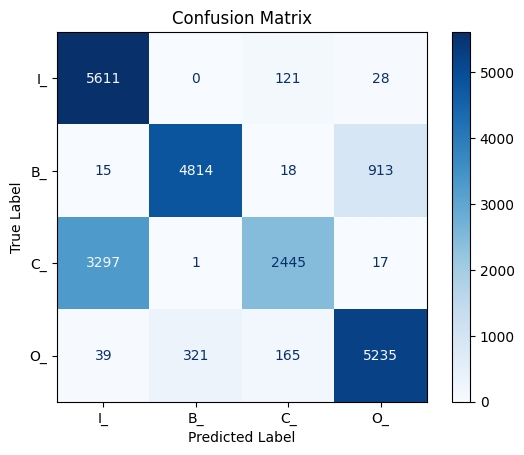

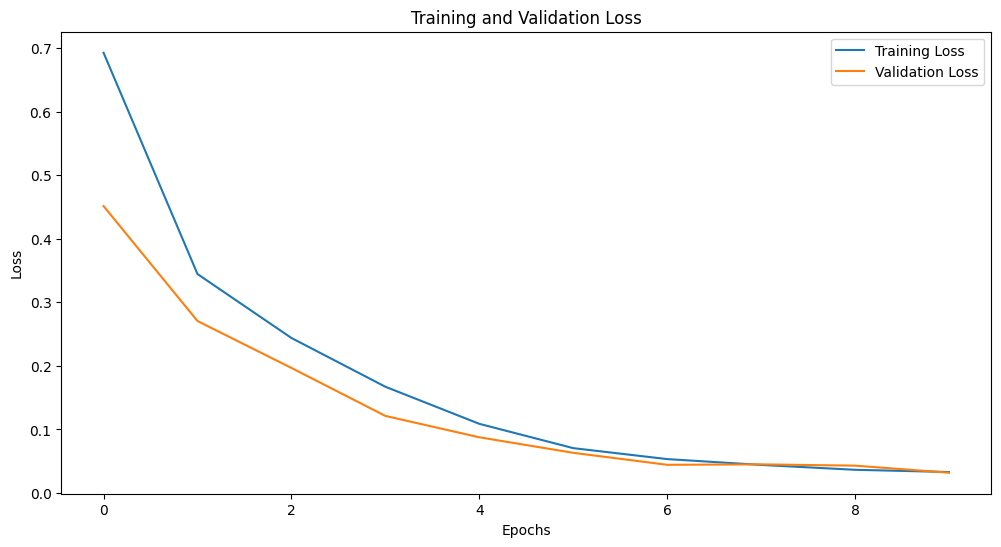

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plotar matriz de confusão adaptada para múltiplas classes
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['I_', 'B_', 'C_', 'O_'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)  # Remover grid extra
plt.show()

# Plotar gráficos de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import os
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, 
    precision_score, recall_score, mean_squared_error, mean_absolute_error
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 🔹 Reduzir logs do TensorFlow para evitar poluição na saída
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ✅ Configuração silenciosa para evitar estouro de memória na GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus and not tf.config.experimental.get_memory_growth(gpus[0]):
    tf.config.experimental.set_memory_growth(gpus[0], True)

# 📌 **Verificar se a GPU está disponível**
if tf.config.list_physical_devices('GPU'):
    device = "/GPU:0"
else:
    device = "/CPU:0"

# 📌 **Definição de window_size e step_size fixos (200, 50)**
window_size = 200
step_size = 50

# 📌 **Callback para mostrar progresso do treinamento**
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, "
              f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")


# 📌 **Função para criar janelas deslizantes**
def create_sliding_windows_multiclass(df, window_size, step_size, label):
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# 📌 **Função para processar arquivos e criar dataset**
def process_files_multiclass(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        if arquivo.startswith("I_"):
            label = [0, 0, 0, 1]
        elif arquivo.startswith("B_"):
            label = [0, 0, 1, 0]
        elif arquivo.startswith("C_"):
            label = [0, 1, 0, 0]
        elif arquivo.startswith("O_"):
            label = [1, 0, 0, 0]
        else:
            continue
        X, y = create_sliding_windows_multiclass(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.vstack(y_list)


# 🔸 Configurações das diferentes arquiteturas LSTM
lstm_configs = [
    {"layers": [128],       "dropout": False},
    {"layers": [128],       "dropout": True},
    {"layers": [128, 64],   "dropout": False},

     {"layers": [64],   "dropout": True},
    {"layers": [128, 128],  "dropout": False},
    {"layers": [128, 128],  "dropout": True}
]


# 📌 **Lista para armazenar os resultados**
results = []

# -----------------------------------------------------------------------------
# 1) Carregar/criar X_train, y_train, X_test, y_test para window=200, step=50
# -----------------------------------------------------------------------------
print(f"== Preparando dados para Window Size={window_size}, Step Size={step_size} ==")

X_train, y_train = process_files_multiclass(
    pd.concat([df_I_train, df_B_train, df_C_train, df_O_train]),
    window_size, step_size
)
X_test, y_test = process_files_multiclass(
    pd.concat([df_I_test, df_B_test, df_C_test, df_O_test]),
    window_size, step_size
)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


# -----------------------------------------------------------------------------
# 2) Treinar/avaliar para cada configuração de arquitetura (lstm_configs)
# -----------------------------------------------------------------------------
for i, config in enumerate(lstm_configs):
    print(f"\nTreinando o modelo {i + 1} com camadas {config['layers']} e dropout={config['dropout']}...")

    # Construção do modelo LSTM dinâmico (com dropout opcional)
    model = Sequential()
    for j, units in enumerate(config['layers']):
        # return_sequences=True nas camadas intermediárias
        return_sequences = (j < len(config['layers']) - 1)
        model.add(LSTM(units, input_shape=(window_size, 4), activation='tanh', return_sequences=return_sequences))
        if config['dropout']:
            model.add(Dropout(0.2))  # Exemplo: dropout de 20%

    model.add(Dense(4, activation='softmax'))  # 4 classes de saída
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callback de EarlyStopping (opcional, mas comum)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Treino do modelo com GPU, se disponível
    with tf.device(device):
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stopping, TrainingProgressCallback()],
            verbose=1
        )

    # Avaliar o modelo
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calcular métricas
    accuracy = accuracy_score(y_test_labels, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test_labels, y_pred)
    f1_macro = f1_score(y_test_labels, y_pred, average='macro')
    f1_weighted = f1_score(y_test_labels, y_pred, average='weighted')
    precision_macro = precision_score(y_test_labels, y_pred, average='macro')
    precision_weighted = precision_score(y_test_labels, y_pred, average='weighted')
    recall_macro = recall_score(y_test_labels, y_pred, average='macro')
    recall_weighted = recall_score(y_test_labels, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred_probs)
    mae = mean_absolute_error(y_test, y_pred_probs)
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Salvar os resultados
    results.append({
        "Model Config": f"Layers={config['layers']} - Dropout={config['dropout']}",
        "Accuracy": accuracy,
        "Balanced Accuracy": balanced_accuracy,
        "F1 Macro": f1_macro,
        "F1 Weighted": f1_weighted,
        "Precision Macro": precision_macro,
        "Precision Weighted": precision_weighted,
        "Recall Macro": recall_macro,
        "Recall Weighted": recall_weighted,
        "MSE": mse,
        "MAE": mae,
        "Confusion Matrix": conf_matrix,
        "History": history.history  
    })

== Preparando dados para Window Size=200, Step Size=50 ==

Treinando o modelo 1 com camadas [128] e dropout=False...


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Iniciando Época 1/10
Epoch 1/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5164 - loss: 0.9650Época 1 finalizada. Loss: 0.8080, Val Loss: 0.6065, Val Accuracy: 0.7060
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 126s 22ms/step - accuracy: 0.5164 - loss: 0.9649 - val_accuracy: 0.7060 - val_loss: 0.6065

Iniciando Época 2/10
Epoch 2/10
5834/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8039 - loss: 0.4401Época 2 finalizada. Loss: 0.3878, Val Loss: 0.3134, Val Accuracy: 0.8703
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 124s 21ms/step - accuracy: 0.8039 - loss: 0.4401 - val_accuracy: 0.8703 - val_loss: 0.3134

Iniciando Época 3/10
Epoch 3/10
5834/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8732 - loss: 0.3031Época 3 finalizada. Loss: 0.2846, Val Loss: 0.2447, Val Accuracy: 0.8994
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 124s 21ms/step - accuracy: 0.8732 - loss: 0.3031 - val_accuracy: 0.8994 - val_loss: 0.2447

Iniciando Época 4/10
Epoch 4/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accura

/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Iniciando Época 1/10
Epoch 1/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5611 - loss: 0.8620Época 1 finalizada. Loss: 0.7019, Val Loss: 0.5990, Val Accuracy: 0.7166
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 129s 22ms/step - accuracy: 0.5612 - loss: 0.8620 - val_accuracy: 0.7166 - val_loss: 0.5990

Iniciando Época 2/10
Epoch 2/10
5834/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6424 - loss: 0.7296Época 2 finalizada. Loss: 0.6441, Val Loss: 0.4822, Val Accuracy: 0.7600
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 128s 22ms/step - accuracy: 0.6424 - loss: 0.7296 - val_accuracy: 0.7600 - val_loss: 0.4822

Iniciando Época 3/10
Epoch 3/10
5834/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8211 - loss: 0.4063Época 3 finalizada. Loss: 0.3683, Val Loss: 0.2773, Val Accuracy: 0.8833
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 128s 22ms/step - accuracy: 0.8211 - loss: 0.4063 - val_accuracy: 0.8833 - val_loss: 0.2773

Iniciando Época 4/10
Epoch 4/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accura

/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Iniciando Época 1/10
Epoch 1/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5684 - loss: 0.8628Época 1 finalizada. Loss: 0.7513, Val Loss: 0.5137, Val Accuracy: 0.7301
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 303s 52ms/step - accuracy: 0.5684 - loss: 0.8628 - val_accuracy: 0.7301 - val_loss: 0.5137

Iniciando Época 2/10
Epoch 2/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7833 - loss: 0.4686Época 2 finalizada. Loss: 0.4032, Val Loss: 0.2801, Val Accuracy: 0.8780
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 325s 56ms/step - accuracy: 0.7833 - loss: 0.4686 - val_accuracy: 0.8780 - val_loss: 0.2801

Iniciando Época 3/10
Epoch 3/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8925 - loss: 0.2608Época 3 finalizada. Loss: 0.2302, Val Loss: 0.1600, Val Accuracy: 0.9369
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 328s 56ms/step - accuracy: 0.8925 - loss: 0.2608 - val_accuracy: 0.9369 - val_loss: 0.1600

Iniciando Época 4/10
Epoch 4/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accura

Resultados:


,Model Config,Accuracy,Balanced Accuracy,F1 Macro,F1 Weighted,Precision Macro,Precision Weighted,Recall Macro,Recall Weighted,MSE,MAE
0,Layers=[128] - Dropout=False,0.780556,0.780556,0.775067,0.775067,0.799603,0.799603,0.780556,0.780556,0.095822,0.113516
1,Layers=[128] - Dropout=True,0.846962,0.846962,0.842310,0.842310,0.872545,0.872545,0.846962,0.846962,0.068541,0.079063
2,"Layers=[128, 64] - Dropout=False",0.841276,0.841276,0.832658,0.832658,0.878796,0.878796,0.841276,0.841276,0.069566,0.080481


<Figure size 1000x800 with 0 Axes>

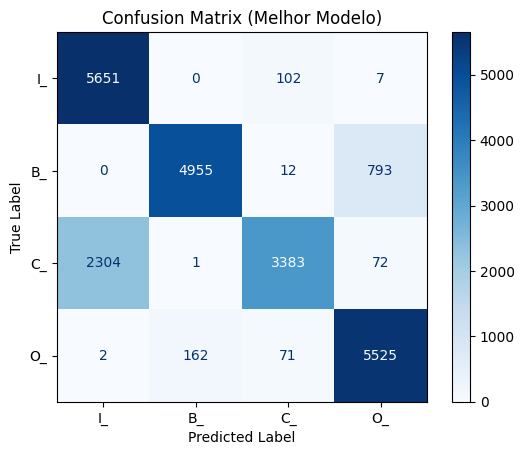

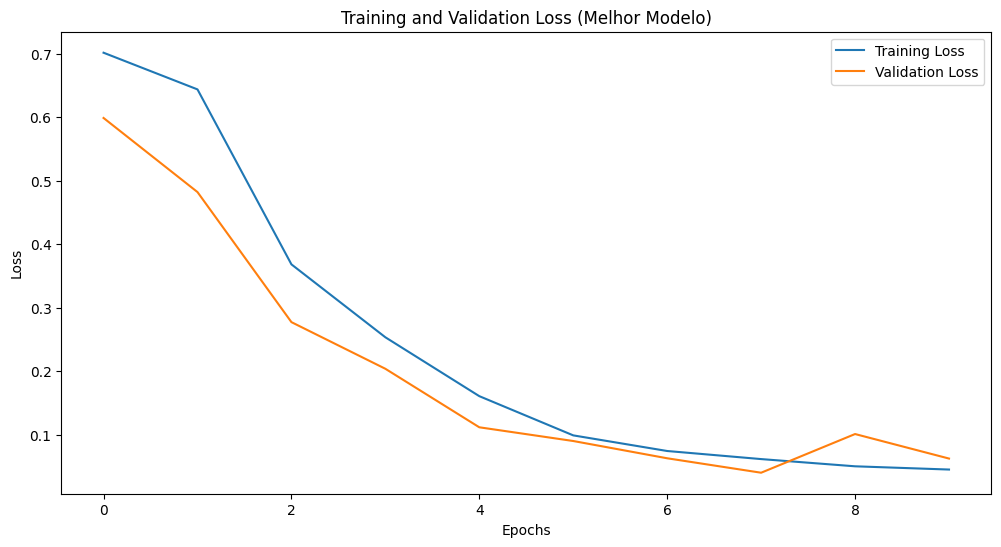

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

# Criar DataFrame com os resultados
results_df = pd.DataFrame(results).drop(columns=["Confusion Matrix", "History"])

# Destacar o melhor resultado para cada métrica
highlighted_results = results_df.style.highlight_max(axis=0, subset=results_df.columns[1:])

# Exibir os resultados
print("Resultados:")
display(results_df)

# Obter o modelo com a melhor Balanced Accuracy
best_model_index = results_df["Balanced Accuracy"].idxmax()
best_model = results[best_model_index]

# Exibir matriz de confusão para o melhor modelo
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=best_model["Confusion Matrix"], display_labels=['I_', 'B_', 'C_', 'O_'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Melhor Modelo)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

# Obter histórico do melhor modelo
history = best_model["History"]

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')  # Sem o `.history`
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Melhor Modelo)')
plt.show()

In [14]:
import os
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, 
    precision_score, recall_score, mean_squared_error, mean_absolute_error
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 🔹 Reduzir logs do TensorFlow para evitar poluição na saída
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ✅ Configuração silenciosa para evitar estouro de memória na GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus and not tf.config.experimental.get_memory_growth(gpus[0]):
    tf.config.experimental.set_memory_growth(gpus[0], True)

# 📌 **Verificar se a GPU está disponível**
if tf.config.list_physical_devices('GPU'):
    device = "/GPU:0"
else:
    device = "/CPU:0"

# 📌 **Definição de window_size e step_size fixos (200, 50)**
window_size = 200
step_size = 50

# 📌 **Callback para mostrar progresso do treinamento**
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, "
              f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")


# 📌 **Função para criar janelas deslizantes**
def create_sliding_windows_multiclass(df, window_size, step_size, label):
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# 📌 **Função para processar arquivos e criar dataset**
def process_files_multiclass(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        if arquivo.startswith("I_"):
            label = [0, 0, 0, 1]
        elif arquivo.startswith("B_"):
            label = [0, 0, 1, 0]
        elif arquivo.startswith("C_"):
            label = [0, 1, 0, 0]
        elif arquivo.startswith("O_"):
            label = [1, 0, 0, 0]
        else:
            continue
        X, y = create_sliding_windows_multiclass(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.vstack(y_list)


# 🔸 Configurações das diferentes arquiteturas LSTM
lstm_configs = [
    {"layers": [64],   "dropout": True},
    {"layers": [128, 128],  "dropout": False},
    {"layers": [128, 128],  "dropout": True}
]


# 📌 **Lista para armazenar os resultados**
results = []

# -----------------------------------------------------------------------------
# 1) Carregar/criar X_train, y_train, X_test, y_test para window=200, step=50
# -----------------------------------------------------------------------------
print(f"== Preparando dados para Window Size={window_size}, Step Size={step_size} ==")

X_train, y_train = process_files_multiclass(
    pd.concat([df_I_train, df_B_train, df_C_train, df_O_train]),
    window_size, step_size
)
X_test, y_test = process_files_multiclass(
    pd.concat([df_I_test, df_B_test, df_C_test, df_O_test]),
    window_size, step_size
)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


# -----------------------------------------------------------------------------
# 2) Treinar/avaliar para cada configuração de arquitetura (lstm_configs)
# -----------------------------------------------------------------------------
for i, config in enumerate(lstm_configs):
    print(f"\nTreinando o modelo {i + 1} com camadas {config['layers']} e dropout={config['dropout']}...")

    # Construção do modelo LSTM dinâmico (com dropout opcional)
    model = Sequential()
    for j, units in enumerate(config['layers']):
        # return_sequences=True nas camadas intermediárias
        return_sequences = (j < len(config['layers']) - 1)
        model.add(LSTM(units, input_shape=(window_size, 4), activation='tanh', return_sequences=return_sequences))
        if config['dropout']:
            model.add(Dropout(0.2))  # Exemplo: dropout de 20%

    model.add(Dense(4, activation='softmax'))  # 4 classes de saída
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callback de EarlyStopping (opcional, mas comum)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Treino do modelo com GPU, se disponível
    with tf.device(device):
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stopping, TrainingProgressCallback()],
            verbose=1
        )

    # Avaliar o modelo
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calcular métricas
    accuracy = accuracy_score(y_test_labels, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test_labels, y_pred)
    f1_macro = f1_score(y_test_labels, y_pred, average='macro')
    f1_weighted = f1_score(y_test_labels, y_pred, average='weighted')
    precision_macro = precision_score(y_test_labels, y_pred, average='macro')
    precision_weighted = precision_score(y_test_labels, y_pred, average='weighted')
    recall_macro = recall_score(y_test_labels, y_pred, average='macro')
    recall_weighted = recall_score(y_test_labels, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred_probs)
    mae = mean_absolute_error(y_test, y_pred_probs)
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Salvar os resultados
    results.append({
        "Model Config": f"Layers={config['layers']} - Dropout={config['dropout']}",
        "Accuracy": accuracy,
        "Balanced Accuracy": balanced_accuracy,
        "F1 Macro": f1_macro,
        "F1 Weighted": f1_weighted,
        "Precision Macro": precision_macro,
        "Precision Weighted": precision_weighted,
        "Recall Macro": recall_macro,
        "Recall Weighted": recall_weighted,
        "MSE": mse,
        "MAE": mae,
        "Confusion Matrix": conf_matrix,
        "History": history.history  
    })

== Preparando dados para Window Size=200, Step Size=50 ==

Treinando o modelo 1 com camadas [64] e dropout=True...


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Iniciando Época 1/10
Epoch 1/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5077 - loss: 0.9851Época 1 finalizada. Loss: 0.8758, Val Loss: 0.8045, Val Accuracy: 0.5995
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 115s 20ms/step - accuracy: 0.5077 - loss: 0.9850 - val_accuracy: 0.5995 - val_loss: 0.8045

Iniciando Época 2/10
Epoch 2/10
5834/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6168 - loss: 0.7792Época 2 finalizada. Loss: 0.7952, Val Loss: 0.6701, Val Accuracy: 0.6583
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 113s 19ms/step - accuracy: 0.6168 - loss: 0.7792 - val_accuracy: 0.6583 - val_loss: 0.6701

Iniciando Época 3/10
Epoch 3/10
5833/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6624 - loss: 0.6731Época 3 finalizada. Loss: 0.6787, Val Loss: 0.5769, Val Accuracy: 0.6972
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 115s 20ms/step - accuracy: 0.6624 - loss: 0.6731 - val_accuracy: 0.6972 - val_loss: 0.5769

Iniciando Época 4/10
Epoch 4/10
5834/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accura

/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Iniciando Época 1/10
Epoch 1/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4825 - loss: 1.0213Época 1 finalizada. Loss: 0.8488, Val Loss: 0.6255, Val Accuracy: 0.6882
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 329s 56ms/step - accuracy: 0.4825 - loss: 1.0213 - val_accuracy: 0.6882 - val_loss: 0.6255

Iniciando Época 2/10
Epoch 2/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7562 - loss: 0.5221Época 2 finalizada. Loss: 0.4856, Val Loss: 0.4537, Val Accuracy: 0.7630
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 352s 60ms/step - accuracy: 0.7562 - loss: 0.5221 - val_accuracy: 0.7630 - val_loss: 0.4537

Iniciando Época 3/10
Epoch 3/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8572 - loss: 0.3367Época 3 finalizada. Loss: 0.3046, Val Loss: 0.2804, Val Accuracy: 0.8817
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 356s 61ms/step - accuracy: 0.8572 - loss: 0.3367 - val_accuracy: 0.8817 - val_loss: 0.2804

Iniciando Época 4/10
Epoch 4/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accura

/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Iniciando Época 1/10
Epoch 1/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5397 - loss: 0.9176Época 1 finalizada. Loss: 0.8867, Val Loss: 0.5942, Val Accuracy: 0.6815
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 296s 51ms/step - accuracy: 0.5397 - loss: 0.9176 - val_accuracy: 0.6815 - val_loss: 0.5942

Iniciando Época 2/10
Epoch 2/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6600 - loss: 0.6593Época 2 finalizada. Loss: 0.6062, Val Loss: 0.4863, Val Accuracy: 0.7653
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 317s 54ms/step - accuracy: 0.6600 - loss: 0.6593 - val_accuracy: 0.7653 - val_loss: 0.4863

Iniciando Época 3/10
Epoch 3/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8125 - loss: 0.4161Época 3 finalizada. Loss: 0.3626, Val Loss: 0.2682, Val Accuracy: 0.8917
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 317s 54ms/step - accuracy: 0.8125 - loss: 0.4161 - val_accuracy: 0.8917 - val_loss: 0.2682

Iniciando Época 4/10
Epoch 4/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accura

Resultados:


,Model Config,Accuracy,Balanced Accuracy,F1 Macro,F1 Weighted,Precision Macro,Precision Weighted,Recall Macro,Recall Weighted,MSE,MAE
0,Layers=[64] - Dropout=True,0.672092,0.672092,0.669172,0.669172,0.675725,0.675725,0.672092,0.672092,0.133316,0.167287
1,"Layers=[128, 128] - Dropout=False",0.848915,0.848915,0.842399,0.842399,0.880517,0.880517,0.848915,0.848915,0.069161,0.077281
2,"Layers=[128, 128] - Dropout=True",0.741970,0.741970,0.698062,0.698062,0.800525,0.800525,0.741970,0.741970,0.122722,0.129376


<Figure size 1000x800 with 0 Axes>

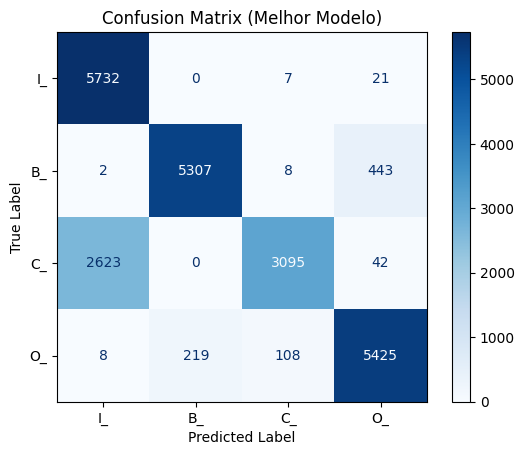

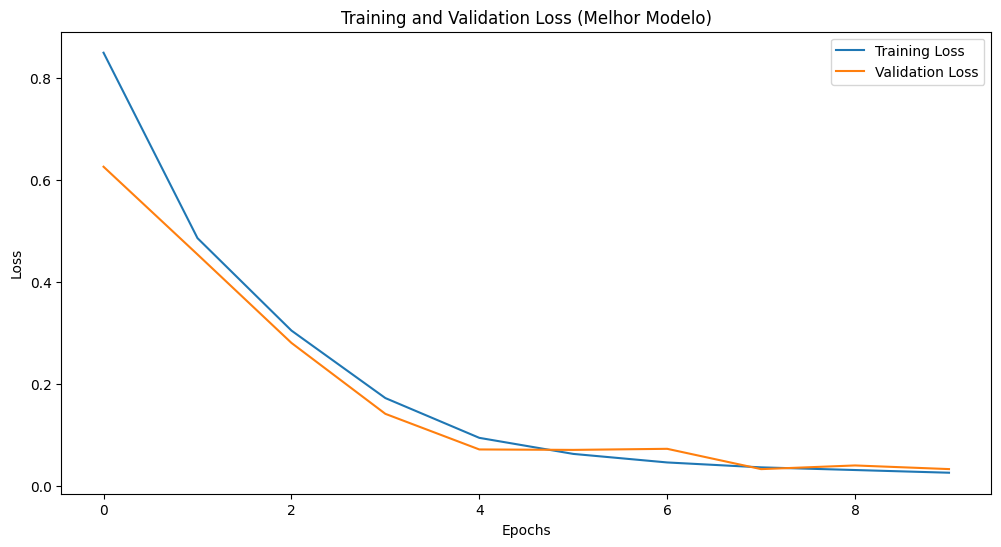

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Criar DataFrame com os resultados
results_df = pd.DataFrame(results).drop(columns=["Confusion Matrix", "History"])

# Destacar o melhor resultado para cada métrica
highlighted_results = results_df.style.highlight_max(axis=0, subset=results_df.columns[1:])

# Exibir os resultados
print("Resultados:")
display(results_df)

# Obter o modelo com a melhor Balanced Accuracy
best_model_index = results_df["Balanced Accuracy"].idxmax()
best_model = results[best_model_index]

# Exibir matriz de confusão para o melhor modelo
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=best_model["Confusion Matrix"], display_labels=['I_', 'B_', 'C_', 'O_'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Melhor Modelo)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

# Obter histórico do melhor modelo
history = best_model["History"]

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')  # Sem o `.history`
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Melhor Modelo)')
plt.show()

In [3]:
import tensorflow as tf
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


✅ TensorFlow-Metal configurado para uso da GPU
Rodando no dispositivo: /GPU:0


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/35
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 307s 52ms/step - accuracy: 0.5091 - loss: 0.9812 - val_accuracy: 0.7160 - val_loss: 0.5348
Epoch 2/35
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 309s 53ms/step - accuracy: 0.6599 - loss: 0.6755 - val_accuracy: 0.7918 - val_loss: 0.4366
Epoch 3/35
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 358s 61ms/step - accuracy: 0.8316 - loss: 0.3817 - val_accuracy: 0.8737 - val_loss: 0.2897
Epoch 4/35
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 360s 62ms/step - accuracy: 0.8911 - loss: 0.2639 - val_accuracy: 0.9453 - val_loss: 0.1408
Epoch 5/35
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 324s 56ms/step - accuracy: 0.9390 - loss: 0.1572 - val_accuracy: 0.9642 - val_loss: 0.0988
Epoch 6/35
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 295s 51ms/step - accuracy: 0.9631 - loss: 0.0973 - val_accuracy: 0.9689 - val_loss: 0.0841
Epoch 7/35
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 281s 48ms/step - accuracy: 0.9750 - loss: 0.0675 - val_accuracy: 0.9818 - val_loss: 0.0494
Epoch 8/35
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 283s 49ms/step - accuracy: 

<Figure size 1000x800 with 0 Axes>

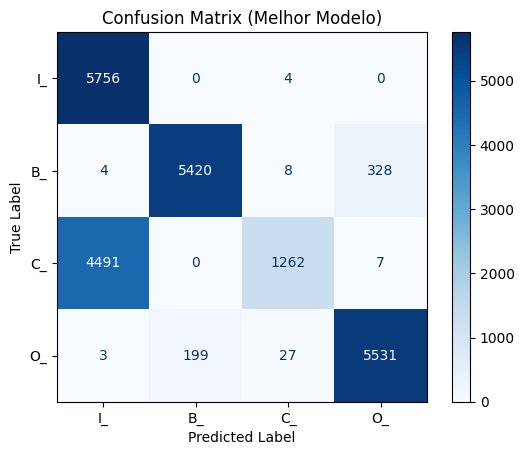

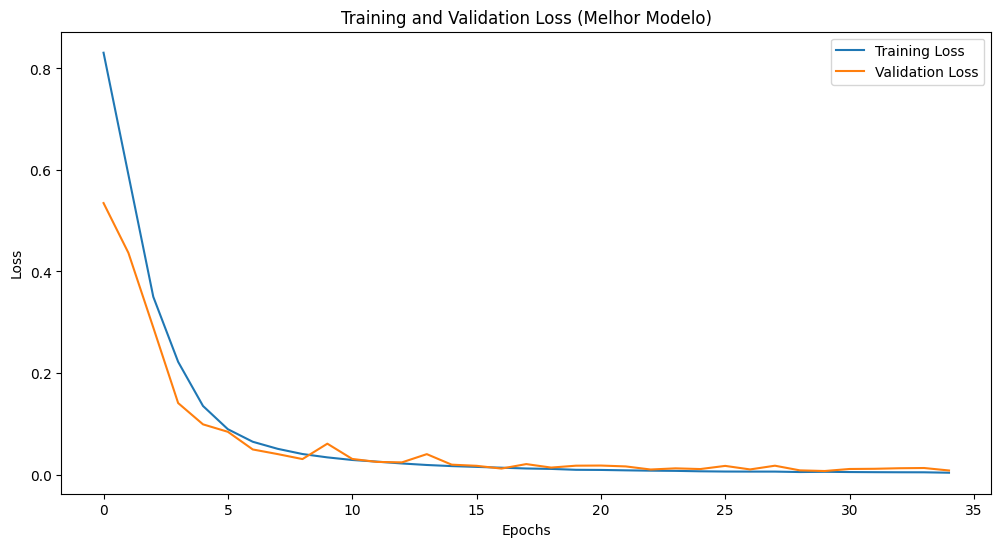

0

In [13]:
import os
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, 
    precision_score, recall_score, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
import numpy as np
import gc

# 🔹 Reduzir logs do TensorFlow para evitar poluição na saída
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 🔥 **Configuração para uso correto da GPU no macOS com TensorFlow-Metal**
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 🔹 Limitar uso de memória para evitar travamentos
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ TensorFlow-Metal configurado para uso da GPU")
    except RuntimeError as e:
        print(f"Erro ao configurar GPU: {e}")
else:
    print("⚠️ Nenhuma GPU disponível! O código será executado na CPU.")

# 📌 **Forçar o uso da GPU, se disponível**
device = "/GPU:0" if gpus else "/CPU:0"
print(f"Rodando no dispositivo: {device}")


# 📌 **Definição de window_size e step_size fixos (200, 50)**
window_size = 200
step_size = 50

# 📌 **Callback para mostrar progresso do treinamento**
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, "
              f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")


# 📌 **Função para criar janelas deslizantes**
def create_sliding_windows_multiclass(df, window_size, step_size, label):
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# 📌 **Função para processar arquivos e criar dataset**
def process_files_multiclass(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        if arquivo.startswith("I_"):
            label = [0, 0, 0, 1]
        elif arquivo.startswith("B_"):
            label = [0, 0, 1, 0]
        elif arquivo.startswith("C_"):
            label = [0, 1, 0, 0]
        elif arquivo.startswith("O_"):
            label = [1, 0, 0, 0]
        else:
            continue
        X, y = create_sliding_windows_multiclass(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.vstack(y_list)


X_train, y_train = process_files_multiclass(
    pd.concat([df_I_train, df_B_train, df_C_train, df_O_train]),
    window_size, step_size
)
X_test, y_test = process_files_multiclass(
    pd.concat([df_I_test, df_B_test, df_C_test, df_O_test]),
    window_size, step_size
)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 🔹 **Treinamento dentro do contexto da GPU**
with tf.device(device):
    # Construção do modelo
    model = Sequential()
    model.add(LSTM(128, input_shape=(window_size, 4), activation='tanh', return_sequences=True))
    model.add(LSTM(128, activation='tanh'))
    model.add(Dense(4, activation='softmax'))  # 4 classes, softmax para probabilidade

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # 🔥 **Treinar o modelo com 50 épocas**
    history = model.fit(
        X_train,
        y_train,
        epochs=35,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )

    # 🔹 **Liberar memória após o treino**
    gc.collect()

    # 🔹 **Avaliar o modelo**
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calcular métricas
    accuracy = accuracy_score(y_test_labels, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test_labels, y_pred)
    f1_macro = f1_score(y_test_labels, y_pred, average='macro')
    f1_weighted = f1_score(y_test_labels, y_pred, average='weighted')
    precision_macro = precision_score(y_test_labels, y_pred, average='macro')
    precision_weighted = precision_score(y_test_labels, y_pred, average='weighted')
    recall_macro = recall_score(y_test_labels, y_pred, average='macro')
    recall_weighted = recall_score(y_test_labels, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred_probs)
    mae = mean_absolute_error(y_test, y_pred_probs)
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Exibir métricas em um DataFrame
metrics = {
    "Accuracy": [accuracy],
    "Balanced Accuracy": [balanced_accuracy],
    "F1 Macro": [f1_macro],
    "F1 Weighted": [f1_weighted],
    "Precision Macro": [precision_macro],
    "Precision Weighted": [precision_weighted],
    "Recall Macro": [recall_macro],
    "Recall Weighted": [recall_weighted],
    "MSE": [mse],
    "MAE": [mae]
}

metrics_df = pd.DataFrame(metrics)
print("Resultados das Métricas:")
print(metrics_df)

# Exibir matriz de confusão
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['I_', 'B_', 'C_', 'O_'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Melhor Modelo)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

# Plotar gráficos de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Melhor Modelo)')
plt.show()

# 🔥 **Liberar memória final após o treino**
K.clear_session()
gc.collect()

In [16]:
import os
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, 
    precision_score, recall_score, mean_squared_error, mean_absolute_error
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc

# 🔹 Reduzir logs do TensorFlow para evitar poluição na saída
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ✅ Configuração para uso eficiente da GPU no macOS com TensorFlow-Metal
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limitar uso de memória para evitar travamentos
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ TensorFlow-Metal configurado para GPU")
    except RuntimeError as e:
        print(f"Erro ao configurar GPU: {e}")
else:
    print("⚠️ Nenhuma GPU disponível! Rodando na CPU.")

# 📌 **Forçar uso da GPU, se disponível**
device = "/GPU:0" if gpus else "/CPU:0"
print(f"Rodando no dispositivo: {device}")

# 📌 **Definição das combinações de tamanho da janela e step**
window_sizes = [200]
step_sizes = [50]

# 🔹 Hiperparâmetros a testar
batch_sizes = [32]
learning_rates = [0.001, 0.01]
optimizers = ['adam']


# 📌 **Função para construir o modelo LSTM**
def build_lstm_model(window_size, dropout_rate=0.5, optimizer_name='adam', learning_rate=0.001):
    # 🔹 Limpar memória antes de criar um novo modelo
    K.clear_session()
    gc.collect()

    if optimizer_name == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Otimizador não suportado: {optimizer_name}")

    model = Sequential([
        LSTM(128, input_shape=(window_size, 4), activation='tanh', return_sequences=True),
        LSTM(128, activation='tanh'),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# 📌 **Lista para armazenar os resultados**
results = []

# 📌 **Iterar sobre todas as combinações de janela e step**

print(f"\n=== Treinando com Window Size={window_size}, Step Size={step_size} ===")

# Criar janelas deslizantes para X_train e X_test
X_train, y_train = process_files_multiclass(
    pd.concat([df_I_train, df_B_train, df_C_train, df_O_train]),
    window_size, step_size
)
X_test, y_test = process_files_multiclass(
    pd.concat([df_I_test, df_B_test, df_C_test, df_O_test]),
    window_size, step_size
)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

for learning_rate in learning_rates:
    
    print(f"\n[HParams] Batch={32}, LR={learning_rate}, Optimizer={Adam}")

    # 📌 **Construir o modelo**
    model = build_lstm_model(
        window_size=window_size,
        dropout_rate=0.5,
        learning_rate=learning_rate
    )

    # 📌 **Early Stopping**
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    )

    # 📌 **Treinar o modelo na GPU**
    with tf.device(device):
        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stopping],
            verbose=1
        )

    # 🔹 **Liberar memória após treinamento**
    gc.collect()

    # 📌 **Avaliar o modelo**
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # 📌 **Calcular métricas**
    metrics_dict = {
        "Window Size": window_size,
        "Step Size": step_size,
        "Batch Size": 32,
        "Learning Rate": learning_rate,
        "Optimizer": Adam,

        "Accuracy": accuracy_score(y_test_labels, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_test_labels, y_pred),
        "F1 Macro": f1_score(y_test_labels, y_pred, average='macro'),
        "F1 Weighted": f1_score(y_test_labels, y_pred, average='weighted'),
        "Precision Macro": precision_score(y_test_labels, y_pred, average='macro'),
        "Recall Macro": recall_score(y_test_labels, y_pred, average='macro'),
        "MSE": mean_squared_error(y_test, y_pred_probs),
        "MAE": mean_absolute_error(y_test, y_pred_probs),
        "Confusion Matrix": confusion_matrix(y_test_labels, y_pred),

        # Guardar histórico do treino
        "History": history.history
    }

    results.append(metrics_dict)

    # 🔹 **Remover modelo da memória**
    del model
    K.clear_session()
    gc.collect()

# 🔹 **Limpeza final da memória após todo o loop**
K.clear_session()
gc.collect()

✅ TensorFlow-Metal configurado para GPU
Rodando no dispositivo: /GPU:0

=== Treinando com Window Size=200, Step Size=50 ===

[HParams] Batch=32, LR=0.001, Optimizer=<class 'keras.src.optimizers.adam.Adam'>


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 221s 38ms/step - accuracy: 0.5052 - loss: 0.9933 - val_accuracy: 0.7083 - val_loss: 0.5780
Epoch 2/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 232s 40ms/step - accuracy: 0.7598 - loss: 0.4919 - val_accuracy: 0.8484 - val_loss: 0.3339
Epoch 3/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 289s 49ms/step - accuracy: 0.8873 - loss: 0.2722 - val_accuracy: 0.9383 - val_loss: 0.1620
Epoch 4/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 291s 50ms/step - accuracy: 0.9476 - loss: 0.1362 - val_accuracy: 0.9690 - val_loss: 0.0817
Epoch 5/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 292s 50ms/step - accuracy: 0.9708 - loss: 0.0796 - val_accuracy: 0.9766 - val_loss: 0.0607
Epoch 6/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 292s 50ms/step - accuracy: 0.9790 - loss: 0.0587 - val_accuracy: 0.9853 - val_loss: 0.0416
Epoch 7/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 291s 50ms/step - accuracy: 0.9845 - loss: 0.0425 - val_accuracy: 0.9827 - val_loss: 0.0442
Epoch 8/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 292s 50ms/step - accuracy: 

/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 278s 48ms/step - accuracy: 0.5564 - loss: 0.8747 - val_accuracy: 0.7308 - val_loss: 0.5668
Epoch 2/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 280s 48ms/step - accuracy: 0.7299 - loss: 0.5419 - val_accuracy: 0.7487 - val_loss: 0.4851
Epoch 3/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 352s 60ms/step - accuracy: 0.7774 - loss: 0.4523 - val_accuracy: 0.8166 - val_loss: 0.3907
Epoch 4/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 328s 56ms/step - accuracy: 0.8109 - loss: 0.4089 - val_accuracy: 0.8155 - val_loss: 0.4027
Epoch 5/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 301s 52ms/step - accuracy: 0.7343 - loss: 0.5332 - val_accuracy: 0.7284 - val_loss: 0.5115
Epoch 6/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 283s 48ms/step - accuracy: 0.7399 - loss: 0.5063 - val_accuracy: 0.7461 - val_loss: 0.5049
720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


0

Resultados dos Hiperparâmetros:


,Window Size,Step Size,Batch Size,Learning Rate,Optimizer,Accuracy,Balanced Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,MSE,MAE
0,200,50,32,0.001,<class 'keras.src.optimizers.adam.Adam'>,0.791450,0.791450,0.773913,0.773913,0.844107,0.791450,0.096804,0.105585
1,200,50,32,0.010,<class 'keras.src.optimizers.adam.Adam'>,0.568186,0.568186,0.560608,0.560608,0.562147,0.568186,0.165569,0.204988


<Figure size 800x600 with 0 Axes>

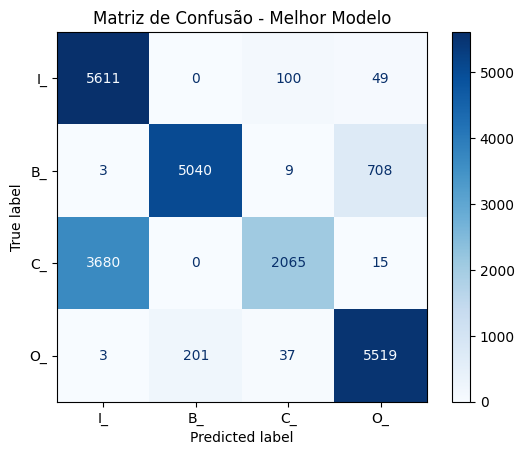

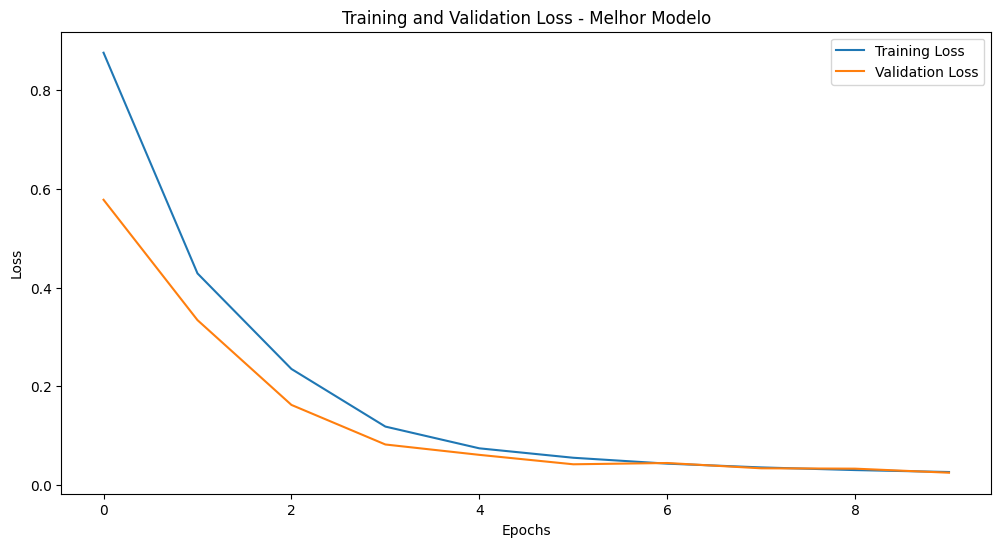

In [17]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay

# Criar DataFrame com os resultados
results_df = pd.DataFrame(results).drop(columns=["Confusion Matrix", "History"])

# Exibir os resultados
print("Resultados dos Hiperparâmetros:")
display(results_df)

# Selecionar o melhor modelo com base na Balanced Accuracy
best_model_idx = results_df["Balanced Accuracy"].idxmax()
best_model_metrics = results[best_model_idx]
best_conf_matrix = best_model_metrics["Confusion Matrix"]
best_history = best_model_metrics["History"]

# Plotar a matriz de confusão do melhor modelo
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=best_conf_matrix, display_labels=['I_', 'B_', 'C_', 'O_'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Melhor Modelo")
plt.show()

# Plotar a Loss do melhor modelo
plt.figure(figsize=(12, 6))
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss - Melhor Modelo")
plt.show()

In [16]:
import os
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, 
    precision_score, recall_score, mean_squared_error, mean_absolute_error
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc

# 🔹 Reduz logs do TensorFlow para evitar poluição
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ✅ Configuração para uso eficiente da GPU no macOS com TensorFlow-Metal
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limitar uso de memória para evitar travamentos
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ TensorFlow-Metal configurado para GPU")
    except RuntimeError as e:
        print(f"Erro ao configurar GPU: {e}")
else:
    print("⚠️ Nenhuma GPU disponível! Rodando na CPU.")

# 📌 **Forçar uso da GPU, se disponível**
device = "/GPU:0" if gpus else "/CPU:0"
print(f"Rodando no dispositivo: {device}")

# 📌 **Configuração do window_size e step_size**
window_size = 200
step_size = 50

# 📌 **Definição das combinações de hiperparâmetros**
hyperparameter_combinations = [
    (0.5, 32, 0.001, 'adam')
]

# Parâmetros de parada antecipada
patience = 5   # Número de épocas sem melhoria antes de parar
min_delta = 0.001  # Mínima redução na loss para considerar melhoria


# 📌 **Callback customizado para parada antecipada**
class CustomEarlyStopping(Callback):
    def __init__(self, patience=5, min_delta=0.001):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("val_loss")
        if current_loss is None:
            return

        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1

        if self.wait >= self.patience:
            print(f"\nParando antecipadamente na época {epoch + 1}. "
                  f"A loss não melhorou significativamente nas últimas {self.patience} épocas.")
            self.model.stop_training = True


# 📌 **Função para construir o modelo LSTM**
def build_lstm_model(dropout_rate, learning_rate):
    # 🔹 Limpar memória antes de criar um novo modelo
    K.clear_session()
    gc.collect()

    opt = Adam(learning_rate=learning_rate)
    model = Sequential([
        LSTM(128, input_shape=(window_size, 4), activation='tanh', return_sequences=True),
        LSTM(128, activation='tanh'),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# 📌 **Função para calcular métricas**
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    
    metrics = {
        "Accuracy": accuracy_score(y_test_labels, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_test_labels, y_pred),
        "F1 Macro": f1_score(y_test_labels, y_pred, average='macro'),
        "F1 Weighted": f1_score(y_test_labels, y_pred, average='weighted'),
        "Precision Macro": precision_score(y_test_labels, y_pred, average='macro'),
        "Recall Macro": recall_score(y_test_labels, y_pred, average='macro'),
        "MSE": mean_squared_error(y_test, y_pred_probs),
        "MAE": mean_absolute_error(y_test, y_pred_probs),
        "Confusion Matrix": confusion_matrix(y_test_labels, y_pred)
    }
    return metrics


# 📌 **Preparação dos dados**
print(f"== Preparando dados para Window Size={window_size}, Step Size={step_size} ==")

X_train, y_train = process_files_multiclass(
    pd.concat([df_I_train, df_B_train, df_C_train, df_O_train]),
    window_size, step_size
)
X_test, y_test = process_files_multiclass(
    pd.concat([df_I_test, df_B_test, df_C_test, df_O_test]),
    window_size, step_size
)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


# 📌 **Loop para testar cada combinação de hiperparâmetros**
results = []
for (dropout_rate, batch_size, learning_rate, opt_name) in hyperparameter_combinations:
    print(f"\nTreinando com Dropout={dropout_rate}, Batch Size={batch_size}, "
          f"Learning Rate={learning_rate}, Optimizer={opt_name}")

    # 📌 **Construir o modelo**
    model = build_lstm_model(dropout_rate, learning_rate)
    
    # 📌 **Callbacks de Early Stopping**
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        min_delta=min_delta
    )
    custom_stopping = CustomEarlyStopping(patience=patience, min_delta=min_delta)
    
    # 📌 **Treinar o modelo na GPU**
    with tf.device(device):
        history = model.fit(
            X_train,
            y_train,
            epochs=50,  # Número máximo de épocas
            batch_size=batch_size,
            validation_split=0.1,
            callbacks=[early_stopping, custom_stopping],
            verbose=1
        )

    # 🔹 **Liberar memória após treinamento**
    gc.collect()

    # 📌 **Avaliar o modelo no conjunto de teste**
    metrics = evaluate_model(model, X_test, y_test)
    
    # 📌 **Salvar hiperparâmetros e histórico**
    metrics["Dropout"] = dropout_rate
    metrics["Batch Size"] = batch_size
    metrics["Learning Rate"] = learning_rate
    metrics["Optimizer"] = opt_name
    metrics["History"] = history.history

    results.append(metrics)

    # 🔹 **Remover modelo da memória**
    del model
    K.clear_session()
    gc.collect()

# 🔹 **Limpeza final da memória após todo o loop**
K.clear_session()
gc.collect()

✅ TensorFlow-Metal configurado para GPU
Rodando no dispositivo: /GPU:0
== Preparando dados para Window Size=200, Step Size=50 ==

Treinando com Dropout=0.5, Batch Size=32, Learning Rate=0.001, Optimizer=adam


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 304s 52ms/step - accuracy: 0.5553 - loss: 0.8958 - val_accuracy: 0.8302 - val_loss: 0.3933
Epoch 2/50
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 307s 53ms/step - accuracy: 0.8592 - loss: 0.3315 - val_accuracy: 0.9195 - val_loss: 0.1970
Epoch 3/50
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 329s 56ms/step - accuracy: 0.9244 - loss: 0.1872 - val_accuracy: 0.9601 - val_loss: 0.1114
Epoch 4/50
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 339s 58ms/step - accuracy: 0.9626 - loss: 0.1007 - val_accuracy: 0.9770 - val_loss: 0.0628
Epoch 5/50
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 339s 58ms/step - accuracy: 0.9767 - loss: 0.0639 - val_accuracy: 0.9842 - val_loss: 0.0423
Epoch 6/50
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 339s 58ms/step - accuracy: 0.9822 - loss: 0.0472 - val_accuracy: 0.9878 - val_loss: 0.0353
Epoch 7/50
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 343s 59ms/step - accuracy: 0.9862 - loss: 0.0381 - val_accuracy: 0.9880 - val_loss: 0.0370
Epoch 8/50
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 342s 59ms/step - accuracy: 

0


Métricas:
Accuracy: 0.7923
Balanced Accuracy: 0.7923
F1 Macro: 0.7666
F1 Weighted: 0.7666
Precision Macro: 0.8529
Recall Macro: 0.7923
MSE: 0.0979
MAE: 0.1046
Dropout: 0.5000
Batch Size: 32.0000
Learning Rate: 0.0010
Optimizer: adam


<Figure size 800x600 with 0 Axes>

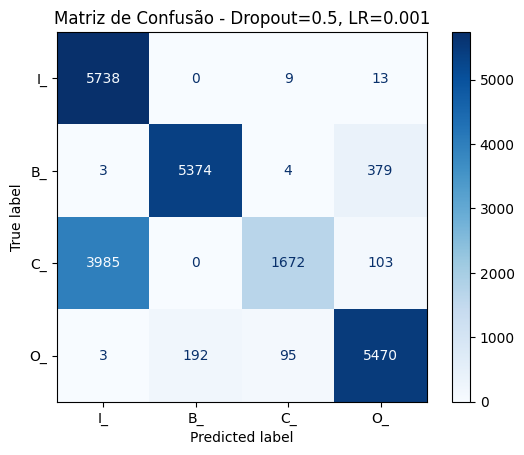

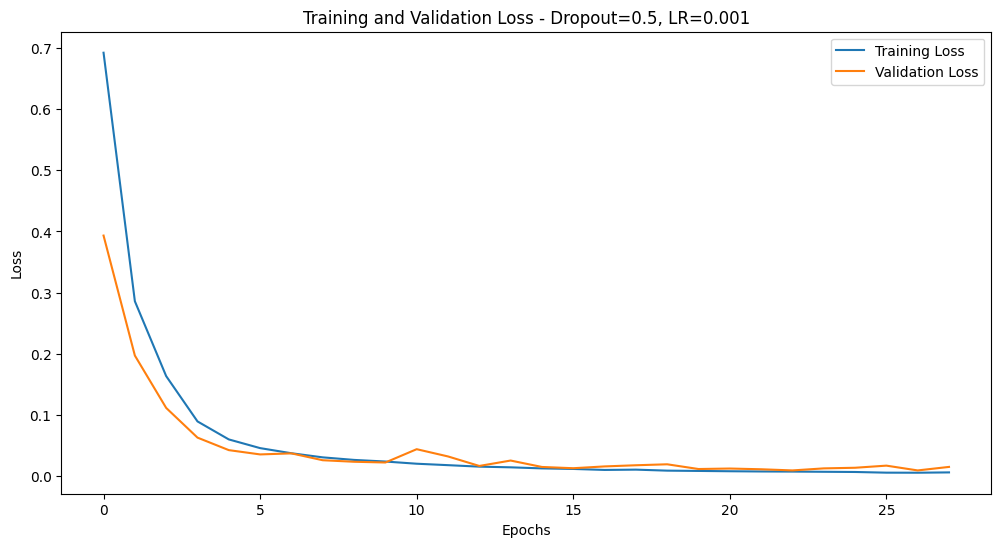

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# Printar as métricas
print("\nMétricas:")
for key, value in metrics.items():
    if key not in ["Confusion Matrix", "History"]:
        if isinstance(value, (int, float)):  # Apenas números formatados com 4 casas decimais
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")  # Para evitar erro de formatação

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"], display_labels=['I_', 'B_', 'C_', 'O_'])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Matriz de Confusão - Dropout={dropout_rate}, LR={learning_rate}")
plt.show()

# Plotar a perda do treinamento e validação
plt.figure(figsize=(12, 6))
plt.plot(metrics["History"]['loss'], label='Training Loss')
plt.plot(metrics["History"]['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Training and Validation Loss - Dropout={dropout_rate}, LR={learning_rate}")
plt.show()

In [ ]:
import os
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, 
    precision_score, recall_score, mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import gc

# 🔹 Reduzir logs do TensorFlow para evitar poluição na saída
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ✅ Configuração silenciosa para evitar estouro de memória na GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limitar uso de memória para evitar travamentos
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ TensorFlow-Metal configurado para GPU")
    except RuntimeError as e:
        print(f"Erro ao configurar GPU: {e}")
else:
    print("⚠️ Nenhuma GPU disponível! Rodando na CPU.")

# 📌 **Forçar uso da GPU, se disponível**
device = "/GPU:0" if gpus else "/CPU:0"
print(f"Rodando no dispositivo: {device}")

# 📌 **Definição das combinações de tamanho da janela e step**
window_sizes = [50, 100, 150, 200, 250]
step_sizes = [50, 100, 150]

# 📌 **Callback para mostrar progresso do treinamento**
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, "
              f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

# 📌 **Função para construir o modelo LSTM**
def build_lstm_model(window_size, dropout_rate=0.5, learning_rate=0.001):
    # 🔹 Liberar memória antes de criar um novo modelo
    K.clear_session()
    gc.collect()

    opt = Adam(learning_rate=learning_rate)
    model = Sequential([
        LSTM(128, input_shape=(window_size, 4), activation='tanh', return_sequences=True),
        LSTM(128, activation='tanh'),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 📌 **Lista para armazenar os resultados**
results = []

# 📌 **Iterar sobre todas as combinações de janela e step**
for window_size in window_sizes:
    for step_size in step_sizes:
        print(f"\n🚀 Treinando com Window Size={window_size}, Step Size={step_size}")

        # Criar janelas deslizantes para X_train e X_test
        X_train, y_train = process_files_multiclass(pd.concat([df_I_train, df_B_train, df_C_train, df_O_train]), window_size, step_size)
        X_test, y_test = process_files_multiclass(pd.concat([df_I_test, df_B_test, df_C_test, df_O_test]), window_size, step_size)

        # Embaralhar os dados de treinamento
        indices_train = np.arange(X_train.shape[0])
        np.random.shuffle(indices_train)
        X_train = X_train[indices_train]
        y_train = y_train[indices_train]

        # Normalizar os dados
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        # 📌 **Construir o modelo**
        model = build_lstm_model(window_size)

        # 📌 **Early Stopping**
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # 📌 **Treinar o modelo na GPU**
        with tf.device(device):
            history = model.fit(
                X_train, y_train,
                epochs=10,
                batch_size=32,
                validation_split=0.1,
                callbacks=[early_stopping, TrainingProgressCallback()],
                verbose=1
            )

        # 🔹 **Liberar memória após treinamento**
        gc.collect()

        # 📌 **Avaliar o modelo**
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)

        # 📌 **Calcular métricas**
        metrics = {
            "Window Size": window_size,
            "Step Size": step_size,
            "Accuracy": accuracy_score(y_test_labels, y_pred),
            "Balanced Accuracy": balanced_accuracy_score(y_test_labels, y_pred),
            "F1 Macro": f1_score(y_test_labels, y_pred, average='macro'),
            "F1 Weighted": f1_score(y_test_labels, y_pred, average='weighted'),
            "Precision Macro": precision_score(y_test_labels, y_pred, average='macro'),
            "Recall Macro": recall_score(y_test_labels, y_pred, average='macro'),
            "MSE": mean_squared_error(y_test, y_pred_probs),
            "MAE": mean_absolute_error(y_test, y_pred_probs),
            "Confusion Matrix": confusion_matrix(y_test_labels, y_pred),
            "History": history.history
        }

        results.append(metrics)

        # 🔹 **Remover modelo da memória**
        del model
        K.clear_session()
        gc.collect()

# 🔹 **Limpeza final da memória após todo o loop**
K.clear_session()
gc.collect()


📌 Resultados das combinações treinadas:
    Window Size  Step Size  Accuracy  Balanced Accuracy  F1 Macro  \
0            50         50  0.709331           0.709331  0.694735   
1            50        100  0.659036           0.659036  0.650842   
2            50        150  0.684477           0.684477  0.672629   
3           100         50  0.728661           0.728661  0.694584   
4           100        100  0.747138           0.747138  0.729340   
5           100        150  0.733481           0.733481  0.729945   
6           150         50  0.760673           0.760673  0.742420   
7           150        100  0.776727           0.776727  0.762435   
8           150        150  0.737246           0.737246  0.731811   
9           200         50  0.922526           0.922526  0.922016   
10          200        100  0.819767           0.819767  0.812185   
11          200        150  0.718506           0.718506  0.715511   

    F1 Weighted  Precision Macro  Recall Macro       MSE     

<Figure size 800x600 with 0 Axes>

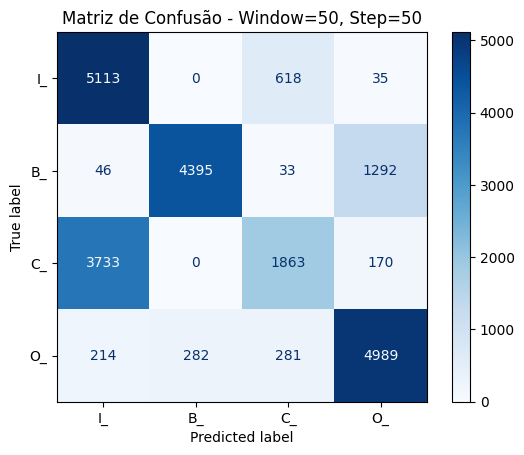

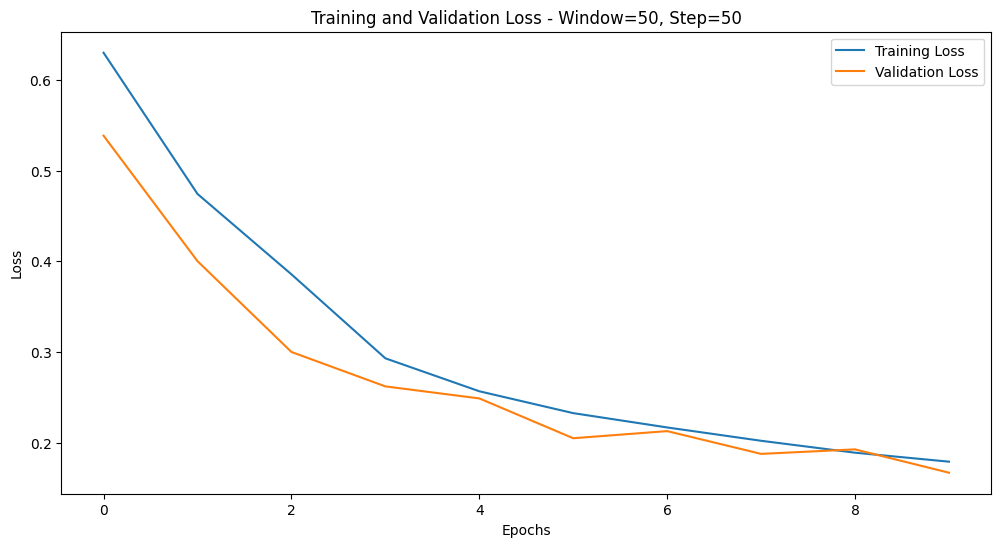

<Figure size 800x600 with 0 Axes>

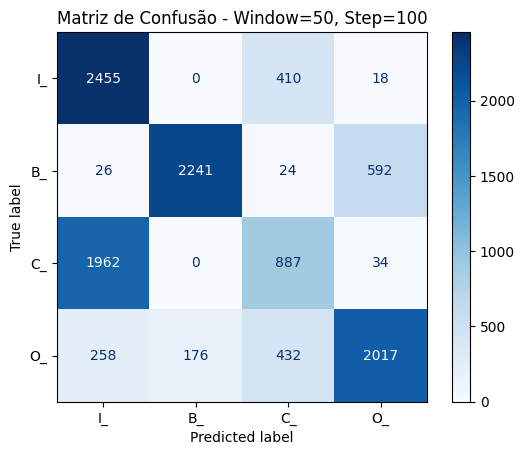

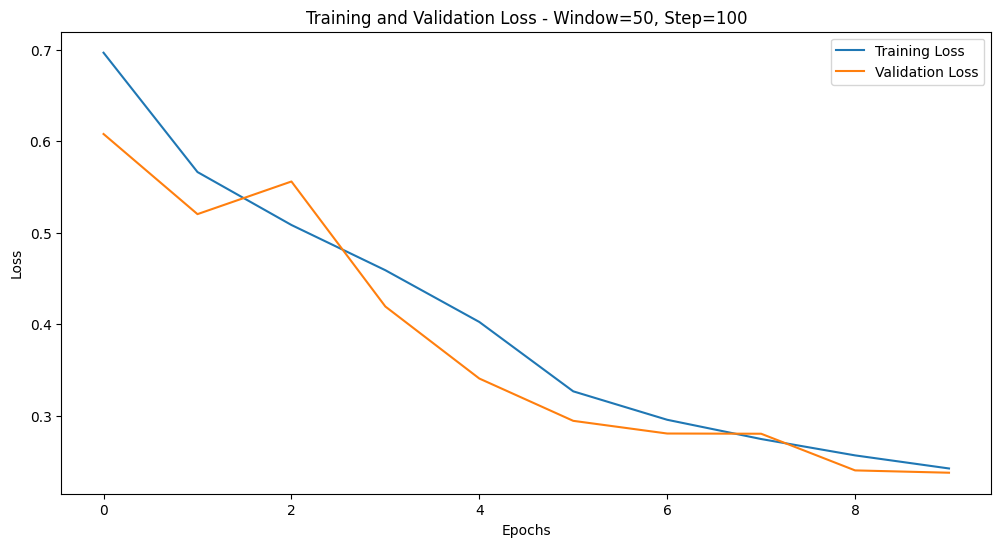

<Figure size 800x600 with 0 Axes>

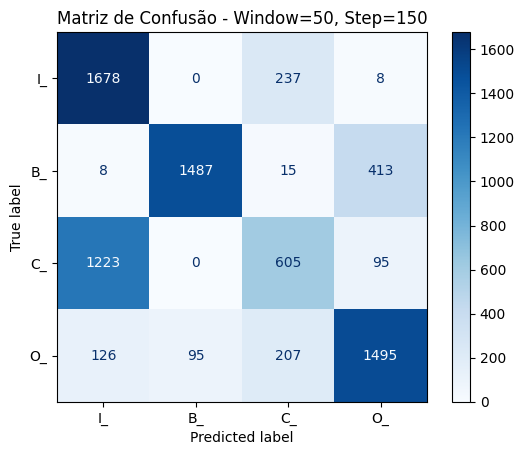

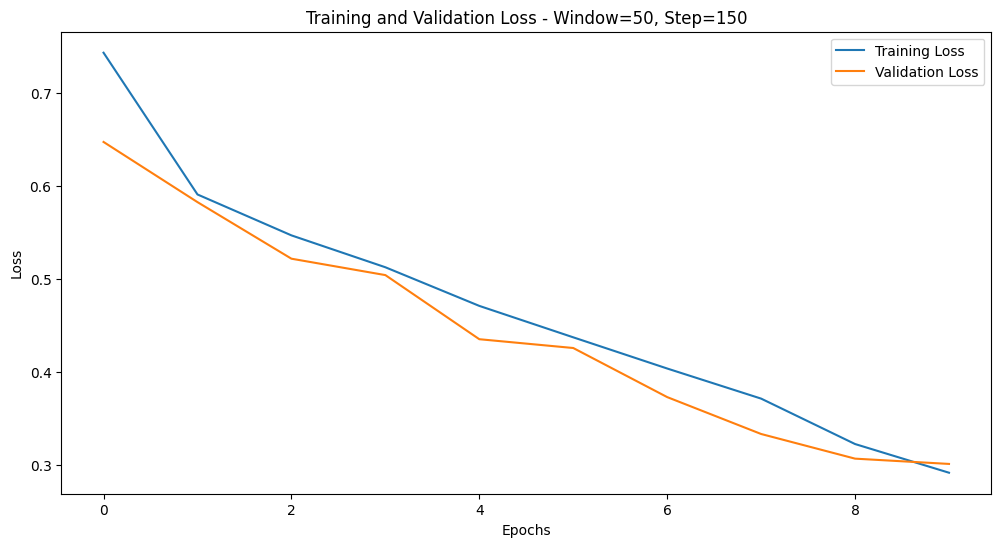

<Figure size 800x600 with 0 Axes>

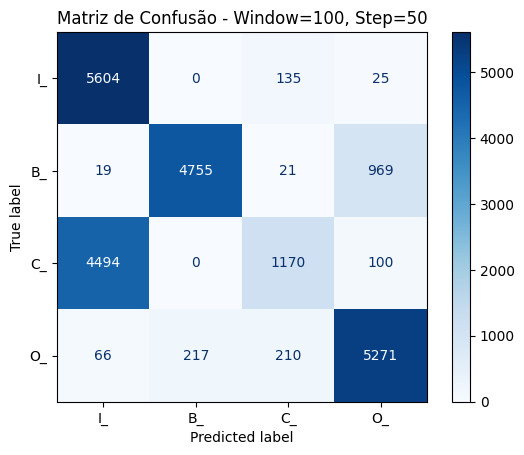

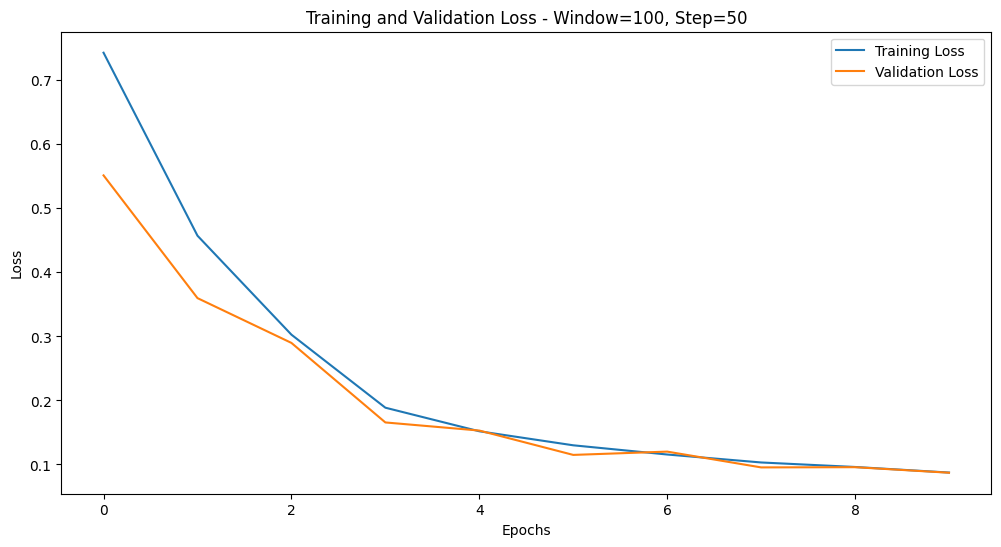

<Figure size 800x600 with 0 Axes>

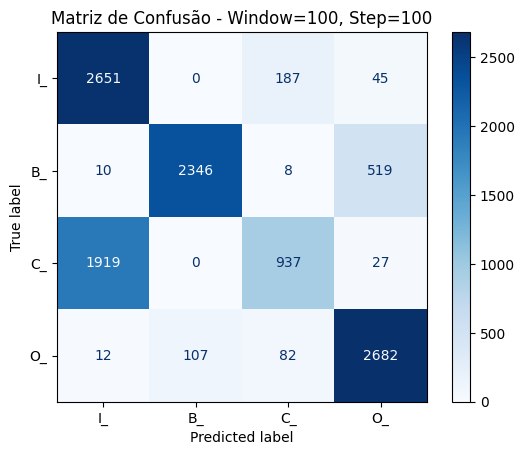

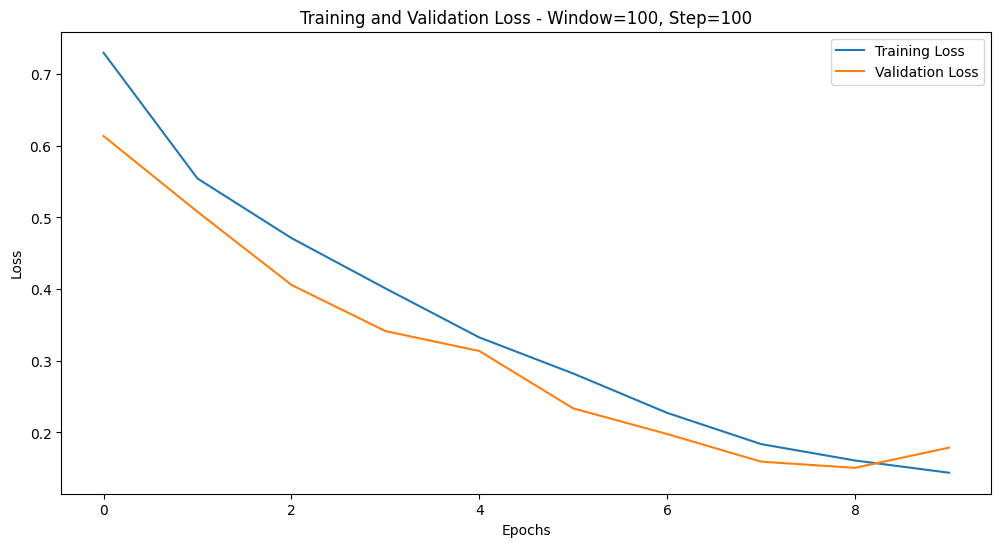

<Figure size 800x600 with 0 Axes>

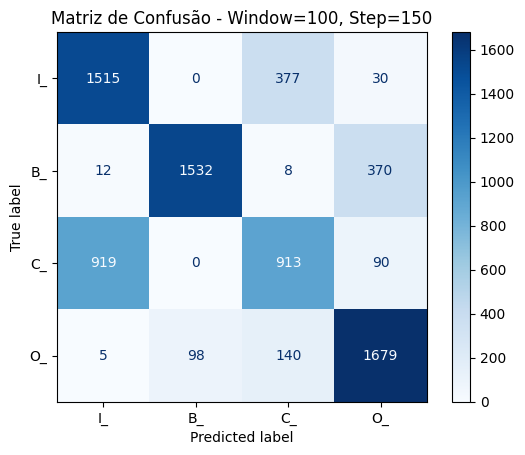

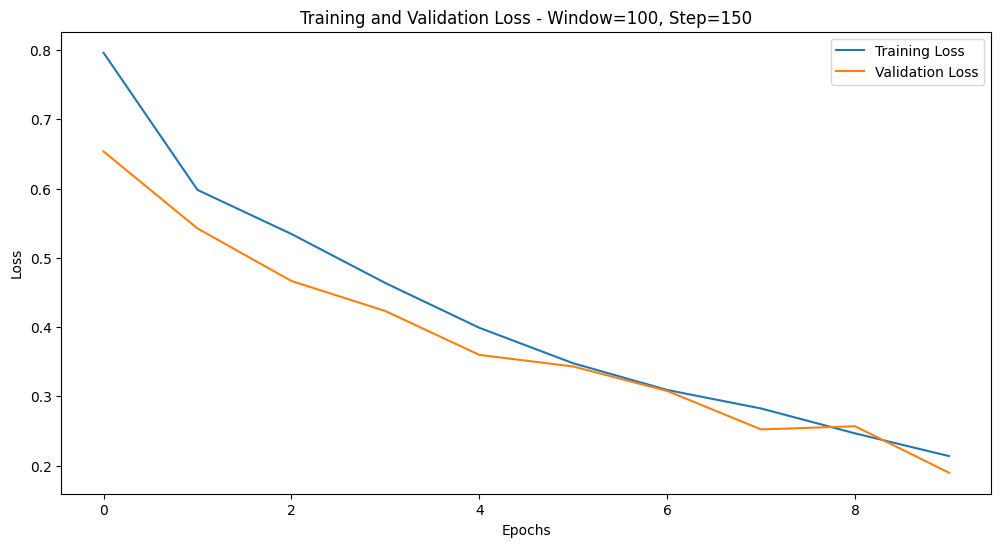

<Figure size 800x600 with 0 Axes>

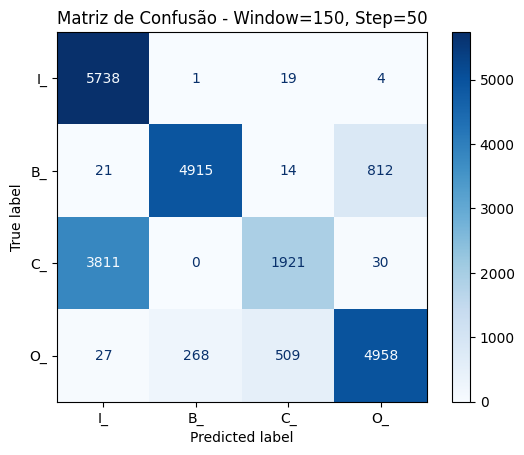

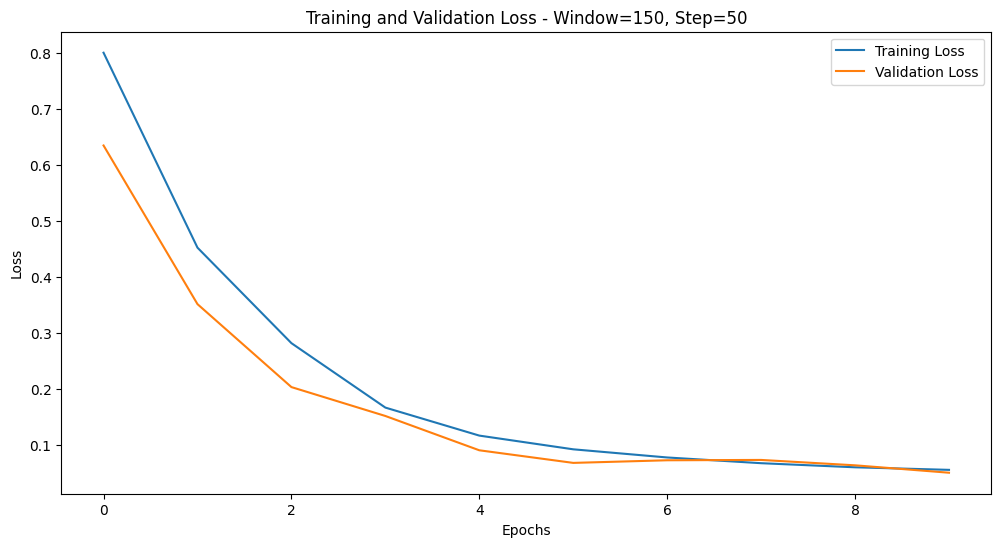

<Figure size 800x600 with 0 Axes>

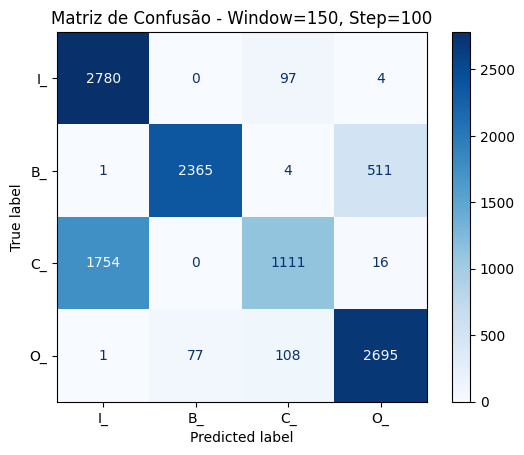

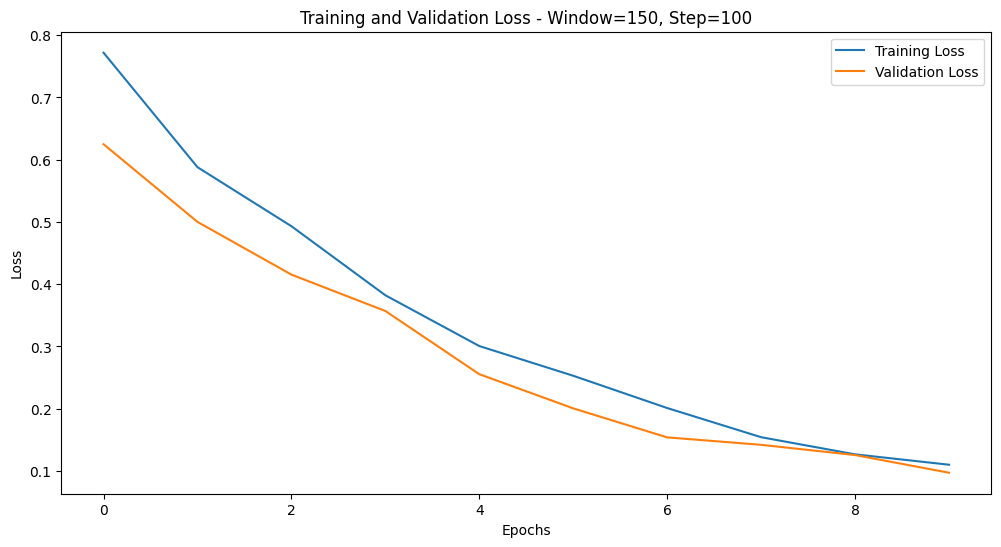

<Figure size 800x600 with 0 Axes>

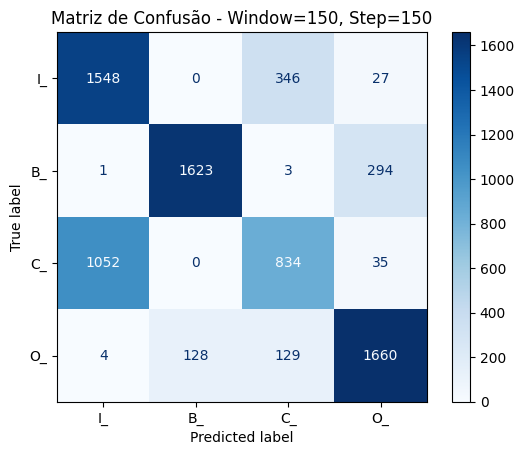

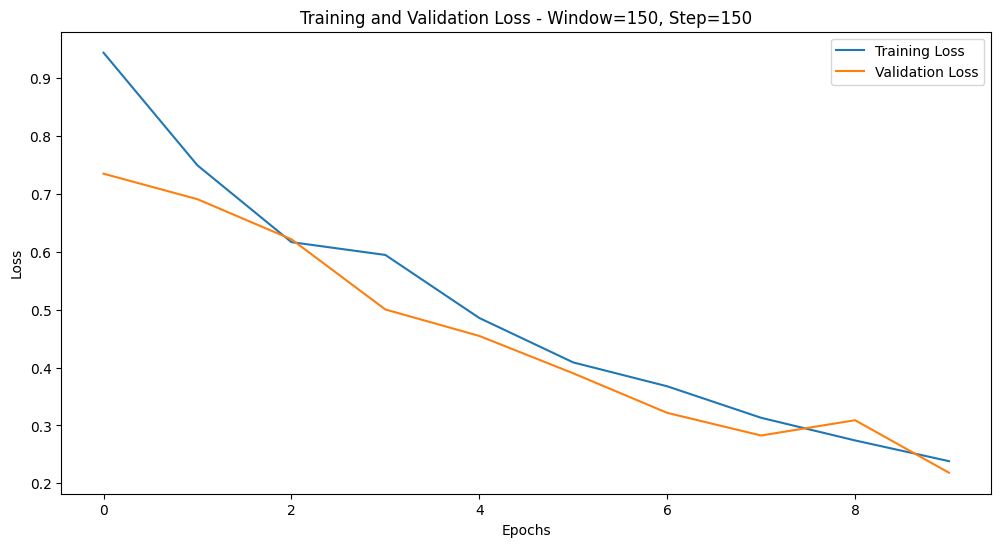

<Figure size 800x600 with 0 Axes>

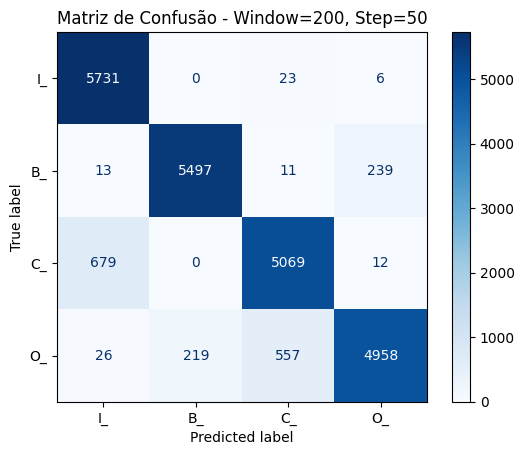

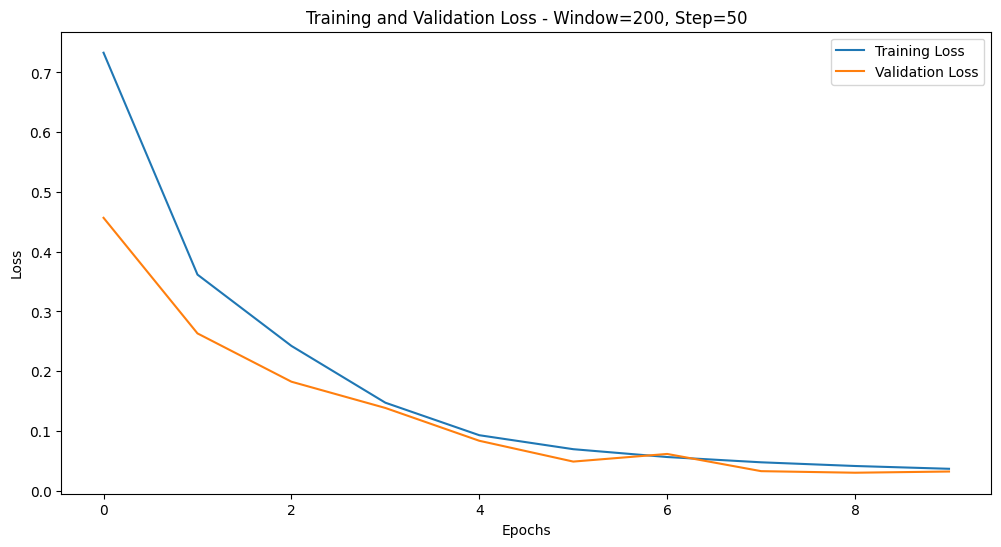

<Figure size 800x600 with 0 Axes>

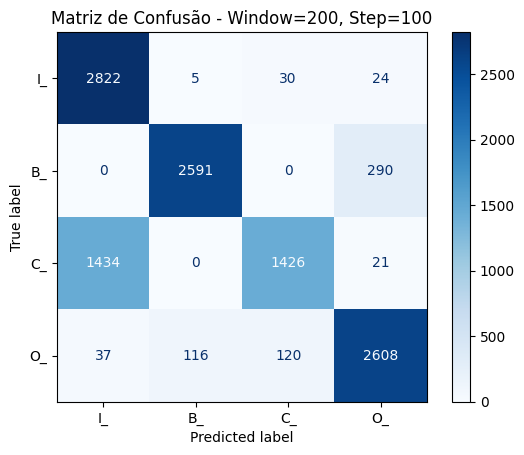

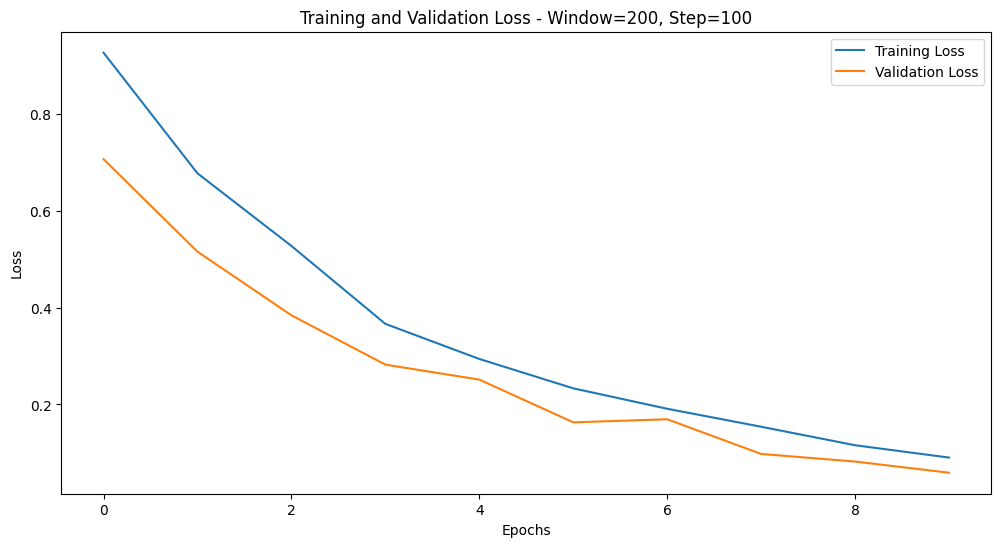

<Figure size 800x600 with 0 Axes>

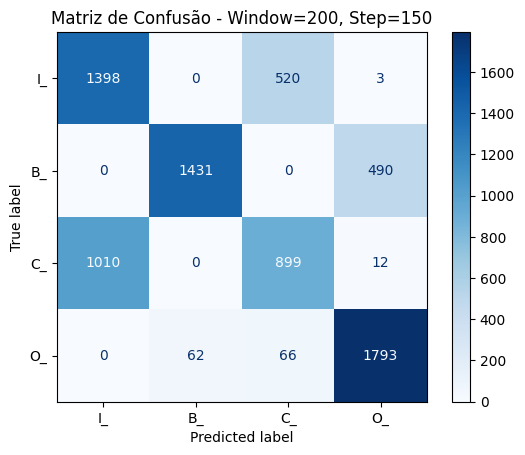

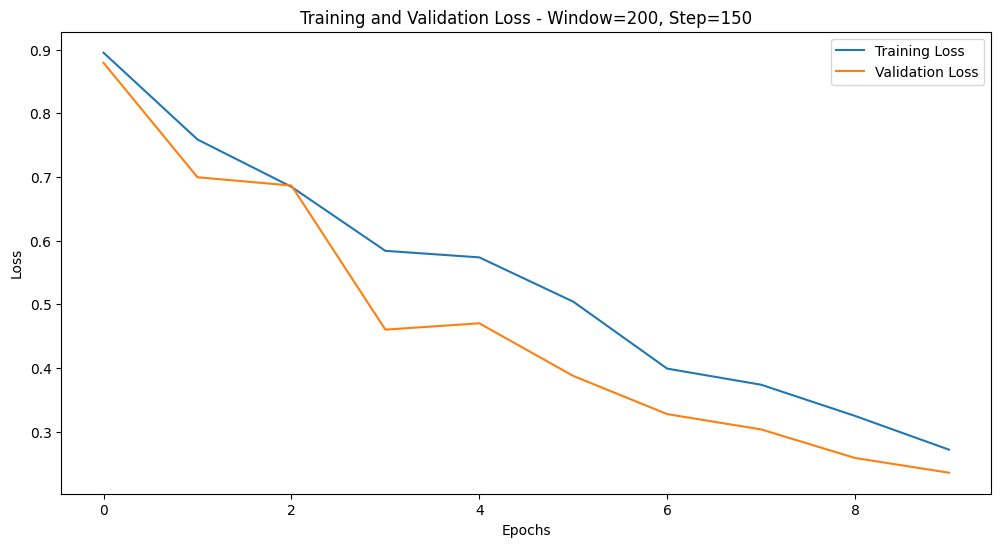

In [20]:
# Criar DataFrame com os resultados
results_df = pd.DataFrame(results).drop(columns=["Confusion Matrix", "History"])

# Exibir os resultados no terminal
print("\n📌 Resultados das combinações treinadas:")
print(results_df)

# **Gerar gráficos**
for metrics in results:
    window_size = metrics["Window Size"]
    step_size = metrics["Step Size"]
    conf_matrix = metrics["Confusion Matrix"]
    history = metrics["History"]

    # Matriz de Confusão
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['I_', 'B_', 'C_', 'O_'])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de Confusão - Window={window_size}, Step={step_size}")
    plt.show()

    # Curva de Perda (Loss)
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Training and Validation Loss - Window={window_size}, Step={step_size}")
    plt.show()